In [44]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.special import gamma, factorial
import itertools
import scipy
from scipy.integrate import trapezoid
import pandas as pd
import numpy.typing as npt

sns.set_theme(style="whitegrid")

# h - Jacobi Polynomials

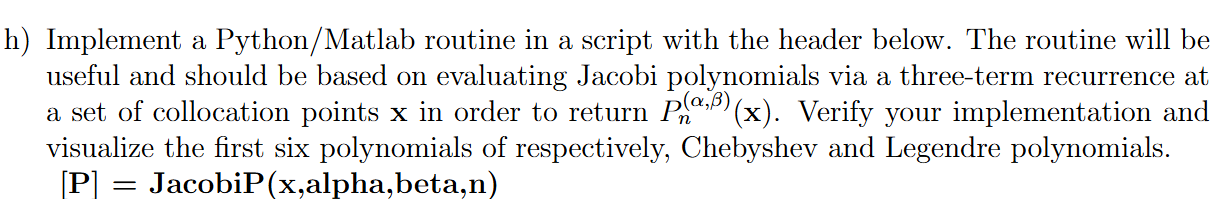

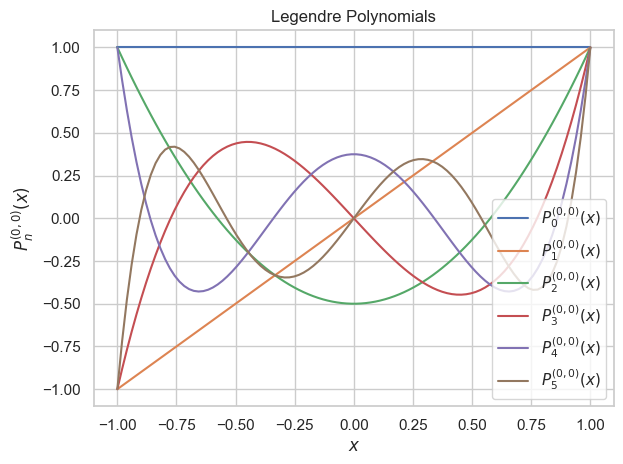

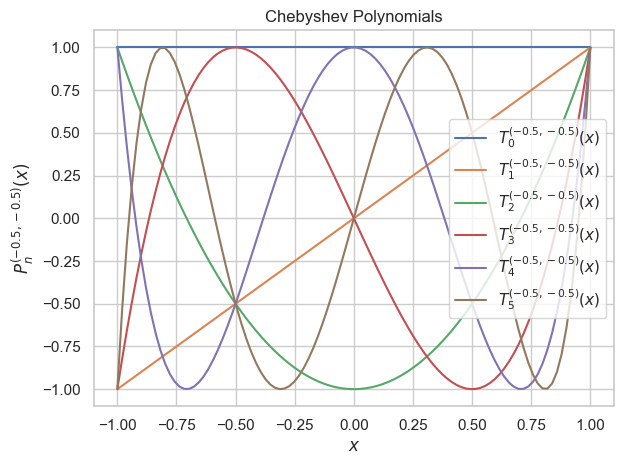

In [45]:
def jacobi_p(x: npt.NDArray, alpha: float, beta: float, n: int) -> npt.NDArray:
    """
    Evaluates first `n+1` Jacobi polynomials at points `x` with parameters `alpha` and `beta`.
    Reflects L2, slide 12.

    Arguments:
        x: Points at which to evaluate the polynomials, shape (m,)
        alpha: Jacobi parameter, $α > -1$
        beta: Jacobi parameter, $β > -1$
        n: Highest order polynomial to compute (must be positive)

    Returns: Array of shape (m, n+1) where each column corresponds to a Jacobi polynomial
    """
    assert n >= 0, "n must be non-negative"

    P = np.empty((len(x), n + 1))

    P[:, 0] = 1.0
    if n == 0:
        return P

    P[:, 1] = 1 / 2 * (alpha - beta + (alpha + beta + 2) * x)
    if n == 1:
        return P

    for k in range(1, n):
        a_nm1_n = (
            2
            * (k + alpha)
            * (k + beta)
            / ((2 * k + alpha + beta + 1) * (2 * k + alpha + beta))
        )
        a_n_n = (alpha**2 - beta**2) / (
            (2 * k + alpha + beta + 2) * (2 * k + alpha + beta)
        )
        a_np1_n = (
            2
            * (k + 1)
            * (k + alpha + beta + 1)
            / ((2 * k + alpha + beta + 2) * (2 * k + alpha + beta + 1))
        )

        P[:, k + 1] = ((a_n_n + x) * P[:, k] - a_nm1_n * P[:, k - 1]) / a_np1_n

    return P


def jacobi_p_normalisation_const(
    alpha: float, beta: float, n: int | npt.NDArray
) -> int | npt.NDArray:
    """
    Computes the normalisation constant for Jacobi polynomials.
    Reflects $γ_n^(α,β)$ from L2, slide 11.

    Arguments:
        alpha: Jacobi parameter, $α > -1$
        beta: Jacobi parameter, $β > -1$
        n: npt.ArrayLike

    Returns: normalisation constant(s) $γ$ for Jacobi polynomials $P_n$
    """
    return (
        2 ** (alpha + beta + 1)
        * (gamma(n + alpha + 1) * gamma(n + beta + 1))
        / (factorial(n) * (2 * n + alpha + beta + 1) * gamma(n + alpha + beta + 1))
    )


def jacobi_p_normalised(
    x: npt.NDArray, alpha: float, beta: float, n: int
) -> npt.NDArray:
    """
    Convenience function to get normalized Jacobi polynomials using `jacobi_p` and `jacobi_p_normalisation_const`.
    """
    P = jacobi_p(x, alpha, beta, n)
    norm_const = jacobi_p_normalisation_const(alpha, beta, np.arange(n + 1))
    return P / np.sqrt(norm_const)


x = np.linspace(-1, 1, 100)

# Legendre
plt.figure()
alpha, beta = 0, 0
for n in [0, 1, 2, 3, 4, 5]:
    P = jacobi_p(x, 0.0, 0.0, n)
    plt.plot(x, P[:, n], label=f"$P_{n}^{{({alpha}, {beta})}}(x)$")

plt.legend()
plt.title("Legendre Polynomials")
plt.xlabel("$x$")
plt.ylabel("$P_n^{(0,0)}(x)$")
plt.tight_layout()

# Chebyshev
plt.figure()
alpha, beta = -0.5, -0.5
for n in [0, 1, 2, 3, 4, 5]:
    P = jacobi_p(x, alpha, beta, n)
    T = (gamma(n + 1) * gamma(0.5)) / gamma(n + 0.5) * P
    plt.plot(x, T[:, n], label=f"$T_{n}^{{({alpha}, {beta})}}(x)$")
plt.legend()
plt.title("Chebyshev Polynomials")
plt.xlabel("$x$")
plt.ylabel("$P_n^{(-0.5,-0.5)}(x)$")
plt.tight_layout()


<P_0, P_0> ≈ 1.000000
<P_0, P_1> ≈ 0.000000
<P_0, P_2> ≈ 0.000000
<P_0, P_3> ≈ 0.000000
<P_0, P_4> ≈ 0.000000
<P_0, P_5> ≈ 0.000000
<P_1, P_1> ≈ 1.000000
<P_1, P_2> ≈ 0.000000
<P_1, P_3> ≈ 0.000000
<P_1, P_4> ≈ 0.000000
<P_1, P_5> ≈ 0.000000
<P_2, P_2> ≈ 1.000000
<P_2, P_3> ≈ 0.000000
<P_2, P_4> ≈ 0.000000
<P_2, P_5> ≈ 0.000000
<P_3, P_3> ≈ 1.000000
<P_3, P_4> ≈ 0.000000
<P_3, P_5> ≈ 0.000001
<P_4, P_4> ≈ 1.000001
<P_4, P_5> ≈ 0.000000
<P_5, P_5> ≈ 1.000001


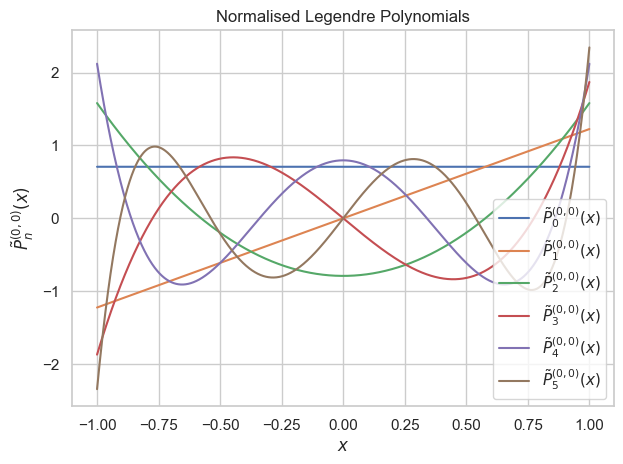

In [46]:
# Check normalised Jacobi polynomials
# Legendre normalised
plt.figure()
alpha, beta = 0, 0

x = np.linspace(-1, 1, 10000)
P = jacobi_p_normalised(x, 0.0, 0.0, n)

P_orthos = []
for i, P_ortho in enumerate(P.T):
    P_orthos.append(P_ortho)
    plt.plot(x, P_ortho, label=f"$\\tilde{{P}}_{i}^{{({alpha}, {beta})}}(x)$")

plt.legend()
plt.title("Normalised Legendre Polynomials")
plt.xlabel("$x$")
plt.ylabel("$\\tilde{P}_n^{(0,0)}(x)$")
plt.tight_layout()

# Check for orthonormality using trapezoidal rule for integration
dx = x[1] - x[0]
for i, v1 in enumerate(P_orthos):
    for j, v2 in enumerate(P_orthos):
        if i <= j:
            integral_approx = trapezoid(v1 * v2, dx=dx)
            print(f"<P_{i}, P_{j}> ≈ {integral_approx:.6f}")

            if i == j:
                assert abs(integral_approx - 1.0) < 1e-3
            else:
                assert abs(integral_approx) < 1e-3

# i - Numerical Experiments using Jacobi Polynomials
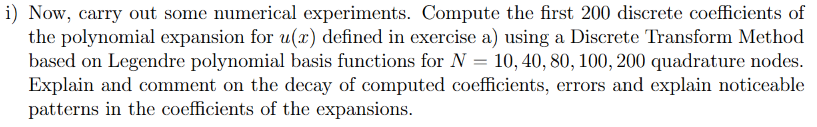

In [47]:
# Gauss-Jacobi quadrature code, adapted from APEK MATLAB code
def JacobiGQ(alpha: float, beta: float, N: int):
    """
    Compute N'th order Gauss-Jacobi quadrature nodes x and weights w
    for weight (1-x)^alpha (1+x)^beta on [-1, 1], with alpha,beta > -1.
    """
    if N == 0:
        x = np.array([-(alpha - beta) / (alpha + beta + 2.0)], dtype=float)
        w = np.array([2.0], dtype=float)  # matches the provided MATLAB code
        return x, w

    J = np.zeros((N + 1, N + 1), dtype=float)
    k = np.arange(0, N + 1, dtype=float)
    h1 = 2.0 * k + alpha + beta

    J[np.arange(N + 1), np.arange(N + 1)] = (
        -0.5 * (alpha**2 - beta**2) / ((h1 + 2.0) * h1)
    )
    if (alpha + beta) < 10.0 * np.finfo(float).eps:
        J[0, 0] = 0.0  # Legendre limit

    kk = np.arange(1, N + 1, dtype=float)
    b = (
        2.0
        / (h1[:-1] + 2.0)
        * np.sqrt(
            kk
            * (kk + alpha + beta)
            * (kk + alpha)
            * (kk + beta)
            / ((h1[:-1] + 1.0) * (h1[:-1] + 3.0))
        )
    )
    J += np.diag(b, 1)
    J += np.diag(b, -1)
    evals, evecs = np.linalg.eigh(J)
    x = evals  # Gauss nodes
    # Weights from first row of normalized eigenvectors
    # mu0 = integral_{-1}^{1} (1-x)^alpha (1+x)^beta dx
    mu0 = (
        (2.0 ** (alpha + beta + 1.0))
        * gamma(alpha + 1.0)
        * gamma(beta + 1.0)
        / gamma(alpha + beta + 2.0)
    )
    w = mu0 * (evecs[0, :] ** 2)

    idx = np.argsort(x)
    x, w = x[idx], w[idx]

    return x, w


def JacobiGL(alpha, beta, N):
    x = np.zeros(N + 1, dtype=float)
    if N == 1:
        x = np.array([-1, 1])
        return x
    xint, _ = JacobiGQ(alpha + 1, beta + 1, N - 2)
    x = np.concatenate((np.array([-1]), xint, np.array([1])))
    return x

C:\Users\jeppe\AppData\Local\Temp\ipykernel_24760\3504966157.py:17: RuntimeWarning: invalid value encountered in divide
  -0.5 * (alpha**2 - beta**2) / ((h1 + 2.0) * h1)


[]

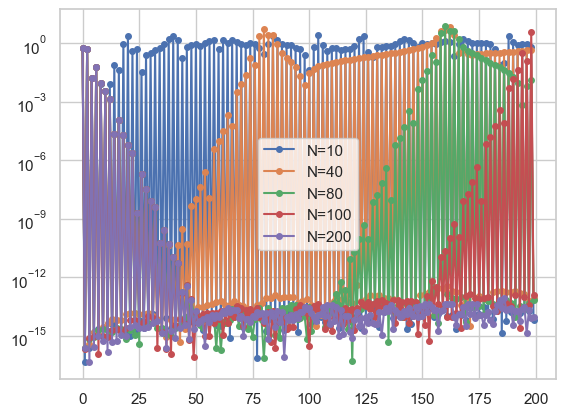

In [48]:
K = 200  # number of discrete coefficients to compute
Ns = [10, 40, 80, 100, 200]  # number of quadrature nodes
alpha = 0.0  # Legendre
beta = 0.0  # Legendre


def u(x):
    # Shift x to match the interval [-1, 1] -> [0, 2]
    x = x - 1.0

    # Scale x to match the interval [0, 2] -> [0, 2π]
    x = x * np.pi

    return 1.0 / (2.0 - np.cos(x))  # This now matches a)


forward_transform_data = []
for i, N in enumerate(Ns):
    # Alternatively we can use scipy.special.roots_jacobi
    # We do this check to validate our JacobiGQ implementation,
    # but we will actually be using JacobiGL for the exercise
    x_nodes_gq, w_nodes_gq = JacobiGQ(alpha, beta, N)
    # NOTE: JacobiGQ is set up a bit strangely, so it actually finds roots of N+1th order polynomial
    x_nodes_scipy_gq, w_nodes_scipy_gq = scipy.special.roots_jacobi(N + 1, alpha, beta)
    assert np.allclose(x_nodes_gq, x_nodes_scipy_gq)
    assert np.allclose(w_nodes_gq, w_nodes_scipy_gq)

    # Since this worked, we feel confident in JacobiGL as well
    # NOTE:
    # JacobiGL arises from taking the derivative (thus gaining alpha+=1, beta+=1, N-=1)
    # and then evaluating at N-=1 more points, and then adding the endpoints -1 and 1
    # See L2, slide 46

    # x_j
    x_nodes = JacobiGL(alpha, beta, N)

    # Compute weights according to L2, slide 46
    # w_j
    w_nodes = 2 / (N * (N + 1)) * 1 / ((jacobi_p(x_nodes, alpha, beta, N) ** 2)[:, N])
    assert w_nodes.shape == (N + 1,)

    # See L2, slide 48
    # f(x_j)
    f_nodes = u(x_nodes)
    # ϕ_k(x_j)
    phi_k = jacobi_p(x_nodes, 0.0, 0.0, K)[:, :K]  # All polynomials up to degree K
    # NOTE: These are not normalised. We should probably do that here
    # but in the lectures it is done at the end when computing the coefficients,
    # so we match that treatment here
    assert phi_k.shape == (N + 1, K)

    # γ_k
    gamma_k = np.sum(phi_k**2 * w_nodes[:, None], axis=0)
    assert gamma_k.shape == (K,)

    f_k = np.sum(f_nodes[:, None] * phi_k * w_nodes[:, None], axis=0) / gamma_k
    assert f_k.shape == (K,)

    plt.plot(range(K), np.abs(f_k), label=f"N={N}", marker="o", markersize=4)

    forward_transform_data.append(
        {
            "N": N,
            "i": i,
            "x_nodes": x_nodes.copy(),
            "w_nodes": w_nodes,
            "f_nodes": f_nodes,
            "phi_k": phi_k,
            "gamma_k": gamma_k,
            "f_k": f_k,
        }
    )

plt.legend()
plt.semilogy()
# plt.semilogy(range(K), np.abs(coeffs), label=f'N={N}', marker='o', markersize=4)
# To implement:
# Root finding method: use Newton-Raphson (L2, slide 38)


# A method in MATLAB seems to exist (and in scipy as well, I think: scipy.special.roots_jacobi)
# If we cannot directly use this, use it to check

Text(0.5, 1.0, 'Reconstruction error')

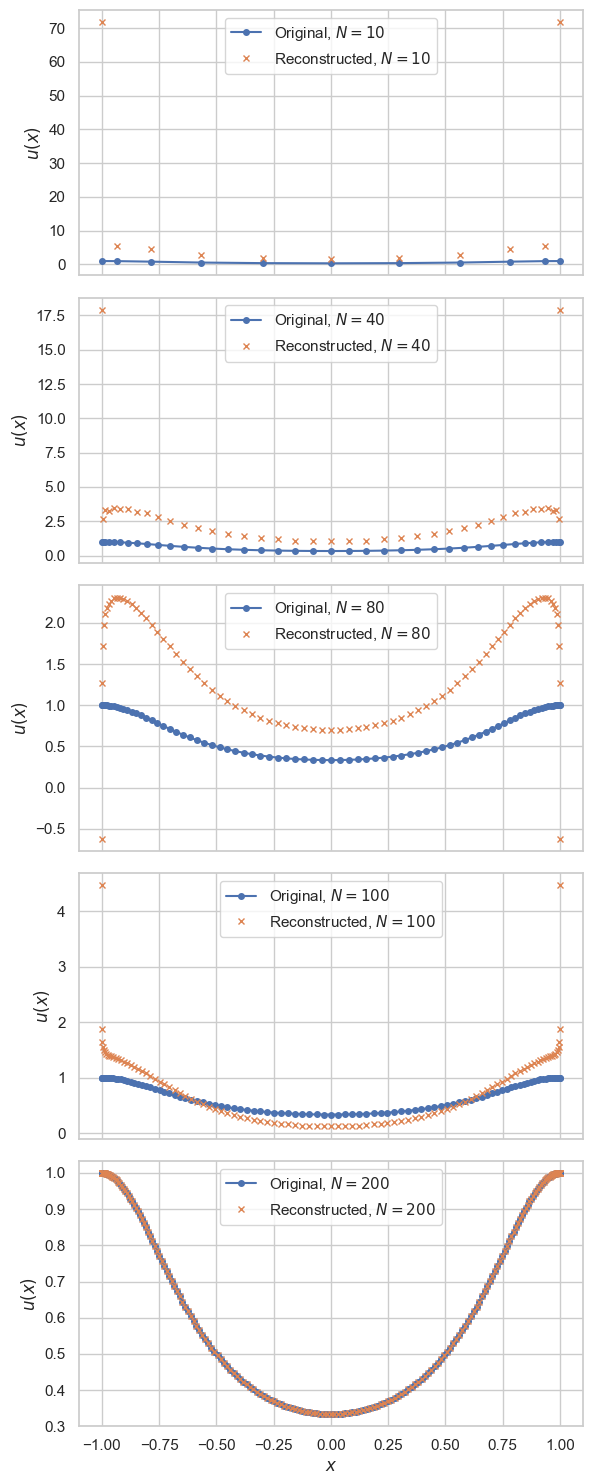

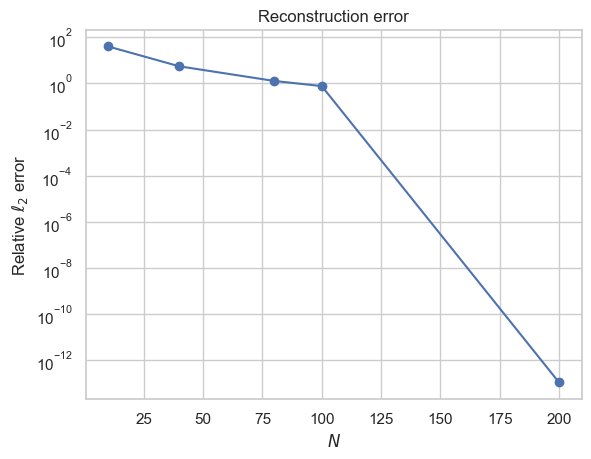

In [49]:
# Test reconstruction using inverse DPT
fig, axes = plt.subplots(len(Ns), 1, figsize=(6, 3 * len(Ns)), sharex=True)
errors = []
for ax, datum in zip(axes, forward_transform_data):
    N = datum["N"]
    # Inverse DPT
    f_nodes_reconstructed = datum["f_k"] @ datum["phi_k"].T
    assert f_nodes_reconstructed.shape == (datum["N"] + 1,)

    ax.plot(
        datum["x_nodes"],
        datum["f_nodes"],
        "-o",
        label=f"Original, $N={N}$",
        markersize=4,
    )
    ax.plot(
        datum["x_nodes"],
        f_nodes_reconstructed,
        "x",
        label=f"Reconstructed, $N={N}$",
        markersize=4,
    )
    ax.legend(loc="upper center")
    ax.set_ylabel("$u(x)$")
    if N == Ns[-1]:
        ax.set_xlabel("$x$")

    error = np.linalg.norm(
        datum["f_nodes"] - f_nodes_reconstructed, ord=2
    ) / np.linalg.norm(datum["f_nodes"], ord=2)
    errors.append(error)

plt.tight_layout()

# Check errors
plt.figure()
plt.semilogy(Ns, errors, "-o")
plt.xlabel("$N$")
plt.ylabel("Relative $ℓ_2$ error")
plt.title("Reconstruction error")

# Looks reasonable


# j - Vandermonde Matrix
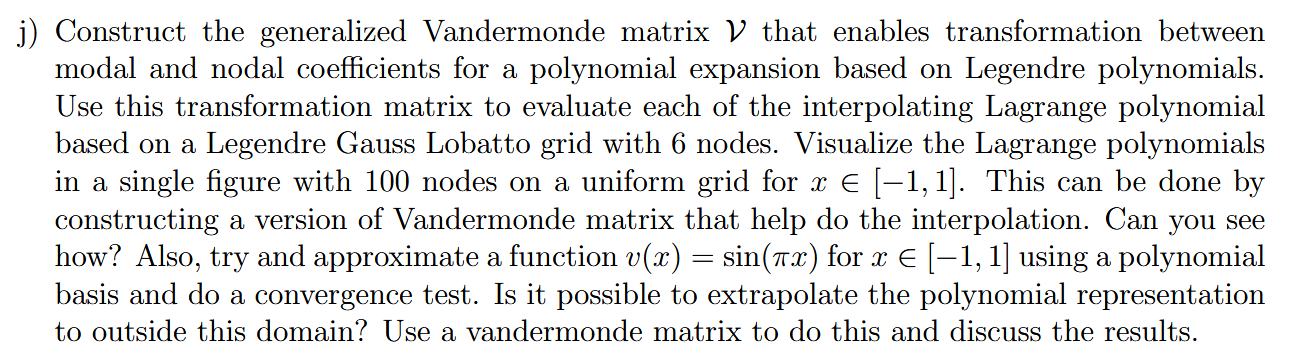

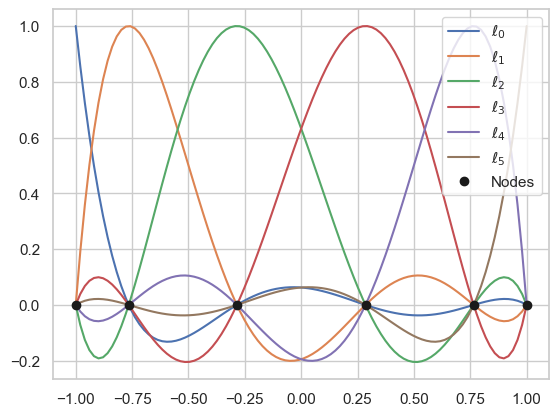

In [50]:
# V_ij is the vandermonde matrix
# def construct_vandermonde
alpha = 0.0  # Legendre
beta = 0.0  # Legendre
N_interpolation = 6
P = N_interpolation - 1  # N-1 order polynomial to pierce N nodes
x_interpolation = JacobiGL(alpha, beta, P)

N_eval = 100
x_eval = np.linspace(-1, 1, N_eval)

# Modal basis functions, Legendre polynomials, evaluated at Lagrange interpolation nodes
V = jacobi_p(x_interpolation, alpha, beta, P)

# Vandermonde used for evaluation grid. Converts from modal basis to nodal basis
V_eval = jacobi_p(x_eval, alpha, beta, P)

# Evaluate interpolated function at evaluation nodes
f_eval_interpolated = V_eval @ np.linalg.inv(V)

# We plot interpolated
plt.figure()
for i in range(N_interpolation):
    plt.plot(x_eval, f_eval_interpolated[:, i], label=f"$ℓ_{i}$")
plt.plot(x_interpolation, [0.0] * N_interpolation, "ko", label="Nodes")
plt.legend()


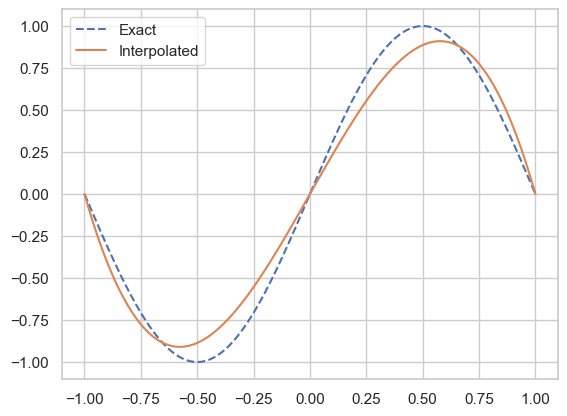

In [51]:
def v(x):
    # Domain: [-1, 1]
    return np.sin(np.pi * x)


x_eval = np.linspace(-1, 1, 1000)
v_exact = v(x_eval)

N = 5
P = N - 1

x_nodes = JacobiGL(alpha, beta, P)
v_nodes = v(x_nodes)

# Construct Vandermonde to convert nodal -> modal
# v_nodal = V @ v_modal => v_modal = V^{-1} @ v_nodal
V = jacobi_p(x_nodes, alpha, beta, P)
v_modal = np.linalg.solve(V, v_nodes)

# Now construct interpolation Vandermonde and use it to go back to nodal
V_eval = jacobi_p(x_eval, alpha, beta, P)
v_nodal_interpolated = V_eval @ v_modal

plt.figure()
plt.plot(x_eval, v_exact, label="Exact", linestyle="--")
plt.plot(x_eval, v_nodal_interpolated, label="Interpolated", linestyle="-")
plt.legend()

[]

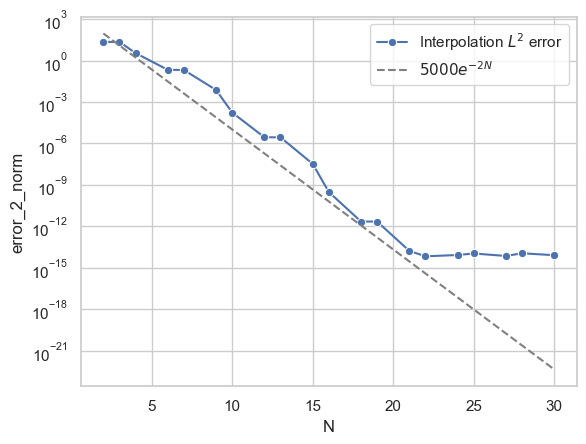

In [52]:
# Same as cell above but now we do convergence plot
Ns = np.linspace(2, 30, 20, dtype=int)
convergence_data = []

x_eval = np.linspace(-1, 1, 1000)
v_exact = v(x_eval)

for N in Ns:
    P = N - 1
    x_nodes = JacobiGL(alpha, beta, P)
    v_nodes = v(x_nodes)

    # Construct Vandermonde to convert nodal -> modal
    V = jacobi_p(x_nodes, alpha, beta, P)
    v_modal = np.linalg.solve(V, v_nodes)

    # Now construct interpolation Vandermonde and use it to go back to nodal
    V_eval = jacobi_p(x_eval, alpha, beta, P)
    v_nodal_interpolated = V_eval @ v_modal

    # Compute the L2 error
    error = np.linalg.norm(v_nodal_interpolated - v_exact, ord=2)
    convergence_data.append(
        {
            "N": N,
            "error_2_norm": error,
        }
    )

df = pd.DataFrame(convergence_data)
sns.lineplot(
    data=df, x="N", y="error_2_norm", marker="o", label="Interpolation $L^2$ error"
)
plt.plot(
    Ns, 5000 * np.exp(-2 * Ns), label="$5000e^{-2N}$", linestyle="--", color="gray"
)
plt.legend()
plt.semilogy()

# Not done: extrapolation

# k - Jacobi Derivatives

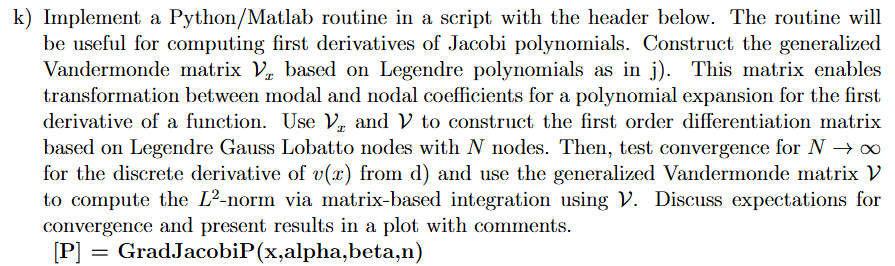

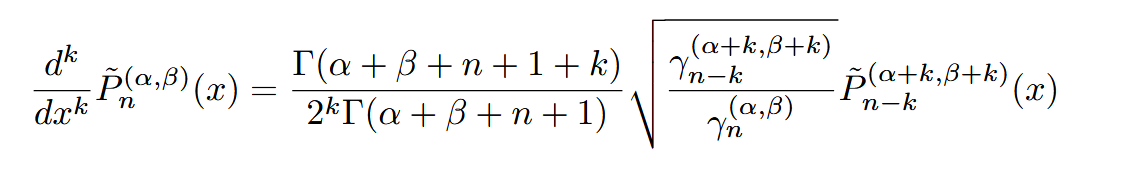

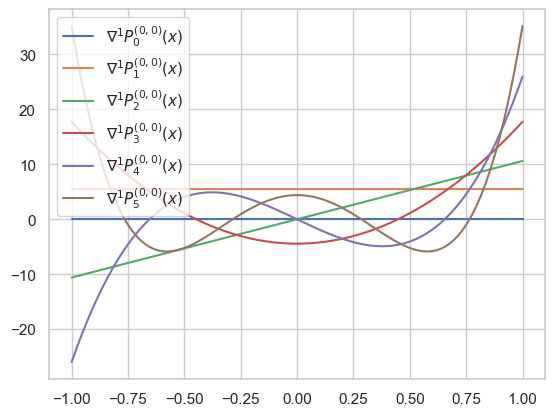

In [53]:
def grad_orthonormal_jacobi_p(x, alpha, beta, n, k):
    grad_ortho_p = np.empty((len(x), n + 1))

    for i in range(n + 1):
        if i == 0:
            p = np.zeros_like(x)
        elif i == 1:
            p = np.ones_like(x)
        else:
            p = jacobi_p_normalised(x, alpha + 1, beta + 1, i - 1)[:, i - 1]

        coeff = (
            1
            * gamma(alpha + beta + n + 1 + k)
            / (2**k * gamma(alpha + beta + n + 1))
            * np.sqrt(
                jacobi_p_normalisation_const(alpha + k, beta + k, n - k)
                / jacobi_p_normalisation_const(alpha, beta, n)
            )
        )

        grad_ortho_p[:, i] = coeff * p

    return grad_ortho_p


x = np.linspace(-1, 1, 100)
plt.figure()
alpha, beta = 0, 0
k = 1
P_grad = grad_orthonormal_jacobi_p(x, alpha, beta, n, k)
for i, p in enumerate(P_grad.T):
    plt.plot(x, p, label=f"$\\nabla^1 P_{{{i}}}^{{({alpha}, {beta})}}(x)$")
plt.legend()


C:\Users\jeppe\AppData\Local\Temp\ipykernel_24760\3889264988.py:39: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


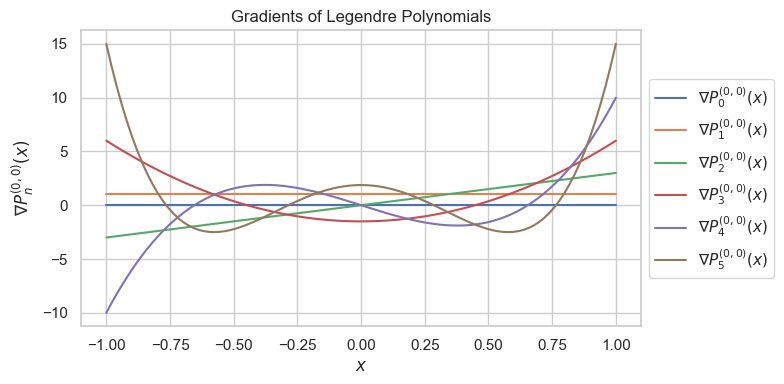

In [54]:
# Actually we should just need the regular one given the lectures, so this is very easy
def grad_jacobi_p(x: npt.NDArray, alpha: float, beta: float, n: int) -> npt.NDArray:
    """
    Computes the gradient of the first `n+1` Jacobi polynomials at nodes `x`.
    Reflects L2, slide 15.

    Arguments:
        x: Points at which to evaluate the gradients, shape (m,)
        alpha: Jacobi parameter, $α > -1$
        beta: Jacobi parameter, $β > -1$
        n: Highest order polynomial to compute (must be positive)
    Returns: Array of shape (m, n+1) where each column corresponds to the gradient of a Jacobi polynomial
    """
    grad_p = np.empty((len(x), n + 1))

    for i in range(n + 1):
        if i == 0:
            p_i = np.zeros_like(x)
        else:
            p_i = jacobi_p(x, alpha + 1, beta + 1, i - 1)[:, i - 1]

        coeff = 1 / 2 * (alpha + beta + i + 1)
        grad_p[:, i] = coeff * p_i

    return grad_p


x = np.linspace(-1, 1, 100)
plt.figure(figsize=(8, 4), layout="constrained")
alpha, beta = 0, 0
P_grads = []
P_grad = grad_jacobi_p(x, alpha, beta, n=6)[:, :6]
for i, p in enumerate(P_grad.T):
    plt.plot(x, p, label=f"$\\nabla P_{{{i}}}^{{({alpha}, {beta})}}(x)$")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.title("Gradients of Legendre Polynomials")
plt.xlabel("$x$")
plt.ylabel("$\\nabla P_n^{(0,0)}(x)$")
plt.tight_layout()
plt.savefig("report/output/2k_polynomial_grad_legendre.png", dpi=600)

[[5.33765131]]


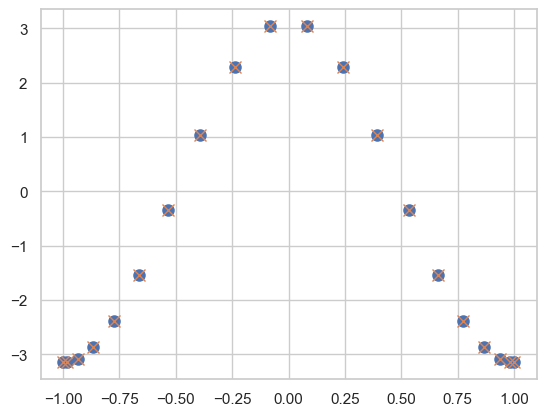

In [56]:
# Redefine just to make sure it is correct function
def v(x):
    return np.sin(np.pi * x)


def dv_dx(x):
    return np.pi * np.cos(np.pi * x)


# V_ij is the vandermonde matrix
alpha = 0.0  # Legendre
beta = 0.0  # Legendre
N_nodes = 20
P_nodes = N_nodes - 1
assert N_nodes > 1

x_nodes = JacobiGL(alpha, beta, P_nodes)
w_nodes = (
    2
    / (N_nodes * (N_nodes + 1))
    * 1
    / ((jacobi_p(x_nodes, alpha, beta, N_nodes) ** 2)[:, N_nodes])
)

# Modal basis functions
V = jacobi_p(x_nodes, alpha, beta, P_nodes)

# Derivatives of modal basis functions at nodes
V_x = grad_jacobi_p(x_nodes, alpha, beta, P_nodes)

diff_matrix = V_x @ np.linalg.inv(V)

# Now get nodes and evaluate
v_nodal = v(x_nodes)

# Evaluate derivative using differentiation matrix
dv_approx_nodal = diff_matrix @ v_nodal
dv_exact_nodal = dv_dx(x_nodes)

# We need to also do integration to get error, which we again do using
# Vandermonde through the mass matrix
M = np.linalg.inv(V @ V.T)
errors = v_nodal - dv_approx_nodal
error_l2 = np.sqrt(errors[:, None].T @ M @ errors[:, None])
print(error_l2)


plt.figure()
plt.plot(x_nodes, dv_approx_nodal, "o", label="Approx derivative", markersize=8)
plt.plot(x_nodes, dv_exact_nodal, "x", label="Exact derivative", markersize=8)


N=5, L2 Error=0.8529678226586327
N=10, L2 Error=0.0002139379832265061
N=15, L2 Error=3.00286872180249e-08
N=20, L2 Error=3.4632200819778486e-14
N=25, L2 Error=1.1051673804396474e-14
N=30, L2 Error=1.2246464922162592e-14
N=35, L2 Error=2.5258621099589638e-14
N=40, L2 Error=2.948451522631189e-14
N=45, L2 Error=3.3796750608789277e-14
N=50, L2 Error=4.009699758919177e-14


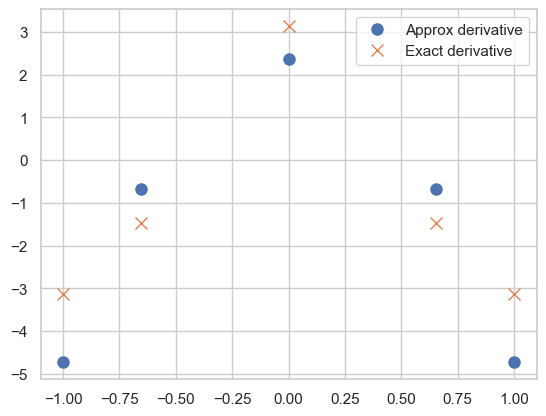

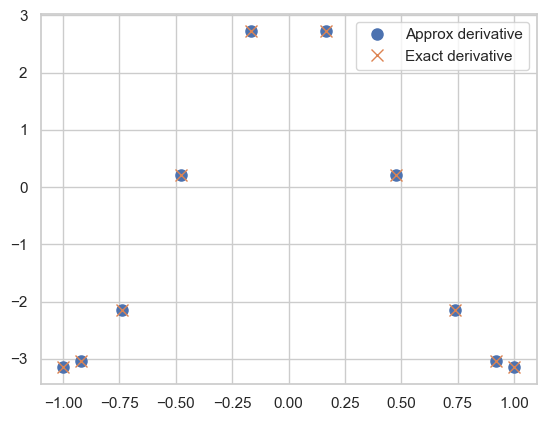

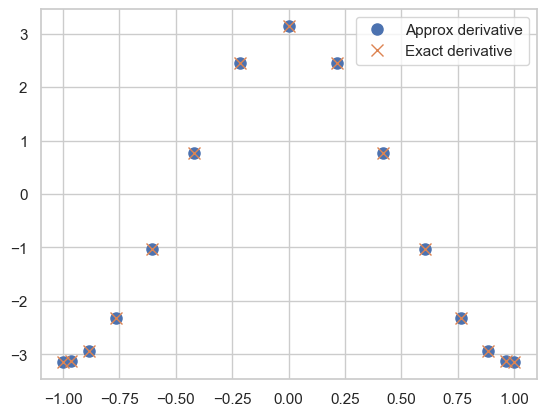

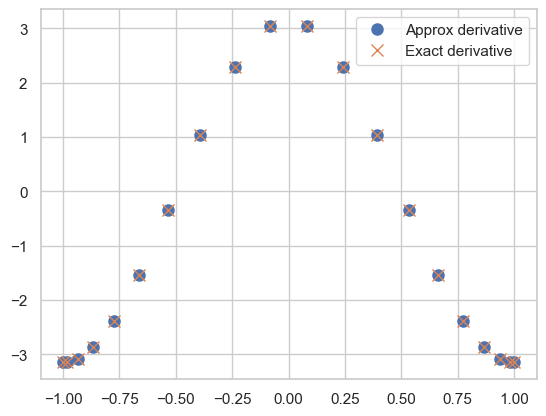

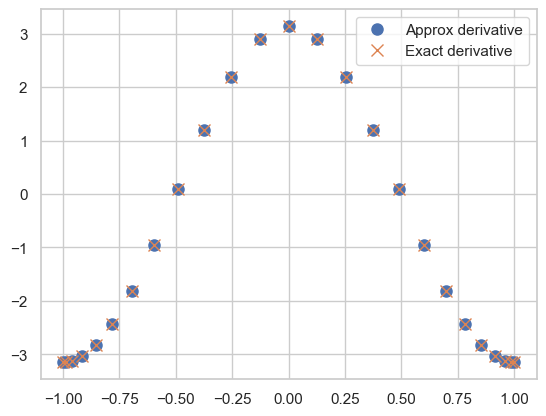

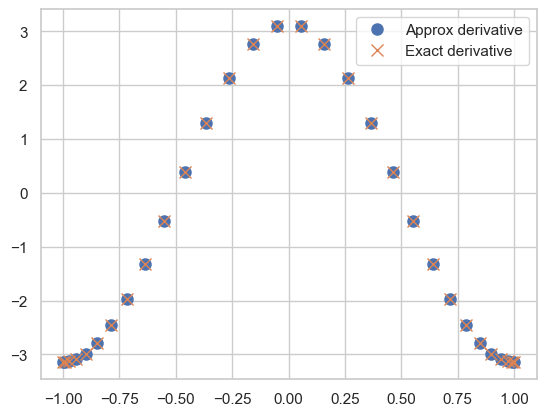

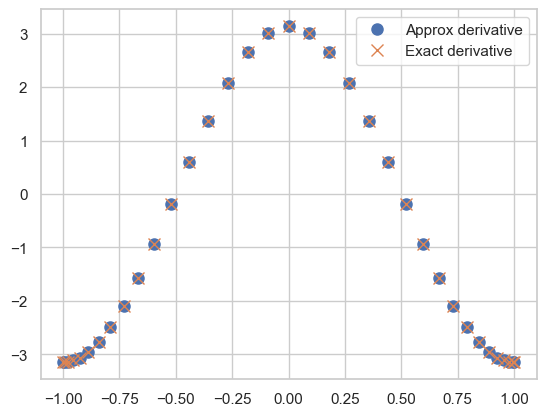

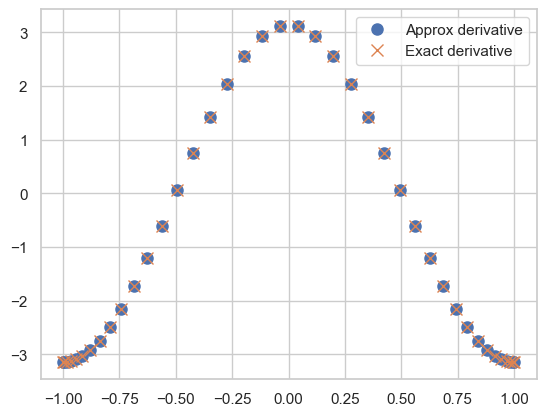

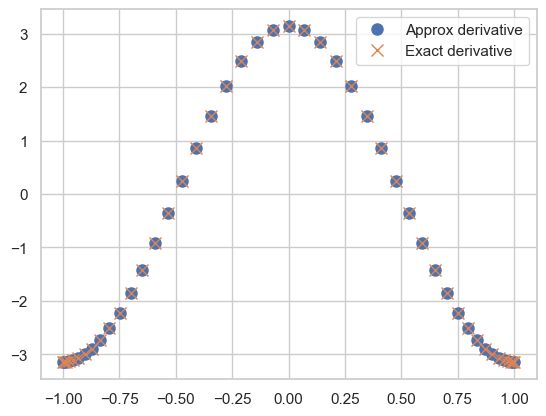

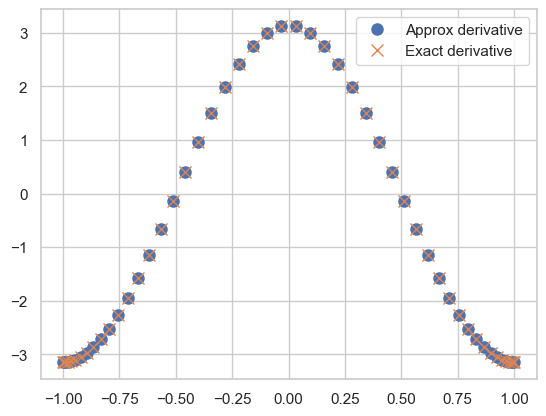

In [57]:
# Redefine just to make sure it is correct function
def v(x):
    return np.sin(np.pi * x)


def dv_dx(x):
    return np.pi * np.cos(np.pi * x)


# V_ij is the vandermonde matrix
alpha = 0.0  # Legendre
beta = 0.0  # Legendre

Ns = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
for N_nodes in Ns:
    P_nodes = N_nodes - 1
    assert N_nodes > 1

    x_nodes = JacobiGL(alpha, beta, P_nodes)
    w_nodes = (
        2
        / (P_nodes * (P_nodes + 1))
        * 1
        / ((jacobi_p(x_nodes, alpha, beta, P_nodes) ** 2)[:, P_nodes])
    )

    # Modal basis functions
    V = jacobi_p(x_nodes, alpha, beta, P_nodes)

    # Derivatives of modal basis functions at nodes
    V_x = grad_jacobi_p(x_nodes, alpha, beta, P_nodes)

    diff_matrix = V_x @ np.linalg.inv(V)

    # Now get nodes and evaluate
    v_nodal = v(x_nodes)

    # Evaluate derivative using differentiation matrix
    dv_approx_nodal = diff_matrix @ v_nodal
    dv_exact_nodal = dv_dx(x_nodes)

    # We need to also do integration to get error, which we again do using
    # Vandermonde through the mass matrix, which must be constructed using the
    # ortho_NORMAL_ polynomials
    V_orthonormal = jacobi_p_normalised(x_nodes, alpha, beta, P_nodes)
    M = np.linalg.inv(V_orthonormal @ V_orthonormal.T)
    errors_nodal = dv_exact_nodal - dv_approx_nodal

    error_l2 = np.sqrt(errors_nodal.T @ M @ errors_nodal)
    print(f"N={N_nodes}, L2 Error={error_l2}")

    plt.figure()
    plt.plot(x_nodes, dv_approx_nodal, "o", label="Approx derivative", markersize=8)
    plt.plot(x_nodes, dv_exact_nodal, "x", label="Exact derivative", markersize=8)
    plt.legend()